# Topic: Predicting P/E Ratios
# Agenda:
    # P/E - Price to Earnings Ratio
        # Price - Current price in the Market
        # Earnings per Share - Last Twelve Months
        # Long Term Indicator of Company Value
    # Data Source/Cleaning
        # US Equities from FinViz
        # ~2700 US Tickers
        # 62 Fundamental Attributes
        # Ignoring Categorical Attributes
    # Data Cleaning
    # Data Exploration / Modeling
        # Linear Regression for Feature Selection
        # KNN Regression
        # Gradient Boosted Tree Regression
    # Model Validation / Inference   

In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import re

In [2]:
#Declare Global Constants
CONST_IN_FILE = './Ticker Attributes 01212015.xlsx'

In [3]:
#Function to Reformat the Ticker Dataframe with proper datatypes
def clean_tickerDataframe(df_ticker):
    #Drop the following Categorical Columns - Price Range, Index, Optionable, Shortable and Earnings (Date)
    #Maybe Include Volume Later
    df_ticker.drop(['52W Range', 'Earnings', 'Index', 'Change', 'Optionable', 'Shortable', 'Volume', 
                    'Price', 'Prev Close', 'Target Price'], axis=1, inplace=True)
    
    #Split the Volatility column in Weekly and Monthly Volatilities respectively. Then Drop the Volatility Column
    df_ticker['Volatility (Weekly)'] = df_ticker['Volatility'].apply(lambda x: x.split(' ')[0].strip())    
    df_ticker['Volatility (Monthly)'] = df_ticker['Volatility'].apply(lambda x: x.split(' ')[1].strip())
    df_ticker.drop('Volatility', axis=1, inplace=True)    

    df_ticker.rename(columns=lambda x: x.strip())
    #Convert to Float all the columns that are objects and have %s in them. Also convert to float all column that have K,M,B as corresponding numbers
    for colHeader in df_ticker.columns:
            col = df_ticker[colHeader]
            #Convert the % columns into Floats after evaluating them and filling NaNs/Empty cells with 0
            if (col.dtype == object) and ('%' in col[0]):
                df_ticker[colHeader] = df_ticker[colHeader].apply(lambda x: x[0:-1].strip())
                df_ticker[colHeader] = df_ticker[colHeader].apply(lambda x: 0 if len(x)==0 else x)              
                df_ticker[colHeader] = df_ticker[colHeader].astype(float)
            elif (col.dtype == object) and ('%' not in col[0]):
                #print colHeader
                df_ticker[colHeader] = df_ticker[colHeader].apply(convertStringtoFloat)
    return df_ticker

In [4]:
#Function to Convert String with (B)illions and (M)illions on it to the relevant numeric values
def convertStringtoFloat(text):
    if('B' in text):
        text = float(text[0:-1]) * 1000000000
    elif('M' in text):
        text = float(text[0:-1]) * 1000000
    elif('K' in text):
        text = float(text[0:-1]) * 1000
    elif('-' in text):
        text = 0.0
    else:
        text = text.strip()
        text = re.sub('[/!@#$()&,"»«+]', '', text)        
        text = float(text)
    return text

In [5]:
#Load Ticker File for analysis
df_tickerDataSet = pd.read_excel(CONST_IN_FILE)
print df_tickerDataSet[['Avg Volume', 'Beta', 'Current Ratio', 'Debt/Eq', 'Dividend', 'Sales', 'P/E', 'RSI (14)', 'Shs Outstand', 'Earnings', 'Volume']].head(5)

     Avg Volume  Beta Current Ratio Debt/Eq Dividend    Sales    P/E RSI (14)  \
A         2.60M  1.54          3.20    0.52     0.40    6.98B  25.46    35.28   
AA       17.68M  1.69          1.50    0.72     0.12   23.92B  70.68    47.56   
AAON    156.34K  1.34          2.70    0.00     0.18  345.00M  29.22    51.28   
AAP     832.66K  0.68          1.30    0.90     0.24    9.02B  24.50    44.82   
AAPL     49.75M  0.89          1.10    0.32     1.88  182.80B  16.91    45.95   

     Shs Outstand    Earnings Volume  
A         335.32M  Feb 11 AMC      0  
AA          1.22B  Jan 12 AMC      0  
AAON       54.47M           -      0  
AAP        72.99M  Feb 12 BMO      0  
AAPL        5.86B  Jan 27 AMC      0  


In [6]:
#Cleaning the Ticker Dataframe
df_tickerDataSet = clean_tickerDataframe(df_tickerDataSet)
print df_tickerDataSet[['Avg Volume', 'Beta', 'Current Ratio', 'Debt/Eq', 'Dividend', 'Sales', 'P/E', 'RSI (14)', 'Shs Outstand', 'Volatility (Weekly)', 'Volatility (Monthly)']].head(5)
print df_tickerDataSet.shape

      Avg Volume  Beta  Current Ratio  Debt/Eq  Dividend         Sales    P/E  \
A        2600000  1.54            3.2     0.52      0.40  6.980000e+09  25.46   
AA      17680000  1.69            1.5     0.72      0.12  2.392000e+10  70.68   
AAON      156340  1.34            2.7     0.00      0.18  3.450000e+08  29.22   
AAP       832660  0.68            1.3     0.90      0.24  9.020000e+09  24.50   
AAPL    49750000  0.89            1.1     0.32      1.88  1.828000e+11  16.91   

      RSI (14)  Shs Outstand  Volatility (Weekly)  Volatility (Monthly)  
A        35.28     335320000                 2.76                  1.88  
AA       47.56    1220000000                 3.91                  2.82  
AAON     51.28      54470000                 3.05                  2.59  
AAP      44.82      72990000                 3.14                  2.04  
AAPL     45.95    5860000000                 2.64                  2.24  
(2743, 62)


In [7]:
#Validated the data types and shape of dataframe
print df_tickerDataSet.dtypes.unique()
assert df_tickerDataSet.dtypes.unique() == 'float64'
print ("Shape of Dataframe:" + str(df_tickerDataSet.shape))

[dtype('float64')]
Shape of Dataframe:(2743, 62)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109dcdc90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10b7ed6d0>]], dtype=object)

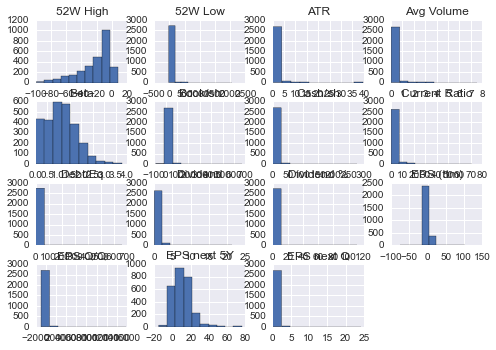

In [8]:
df_tickerDataSet.ix[:,:15].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c8b8490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10b632510>]], dtype=object)

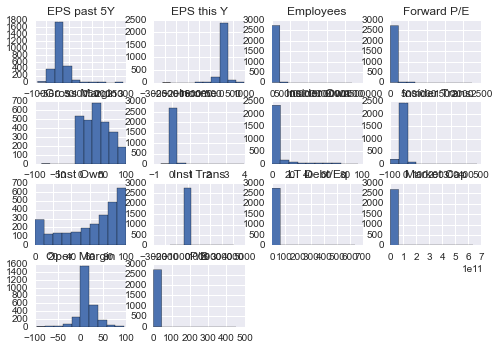

In [9]:
df_tickerDataSet.ix[:,16:30].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c8b8310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10e5f00d0>]], dtype=object)

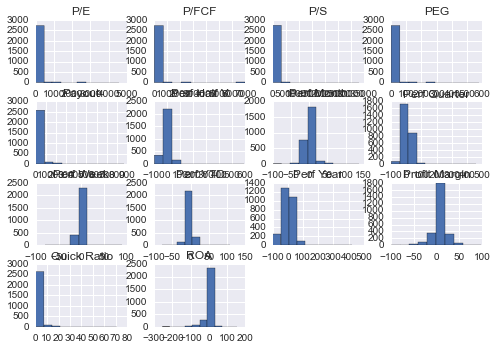

In [10]:
df_tickerDataSet.ix[:,31:45].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f844350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110450910>]], dtype=object)

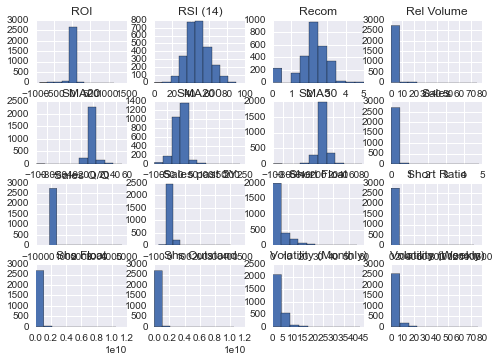

In [11]:
df_tickerDataSet.ix[:,46:].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11133c690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111988790>]], dtype=object)

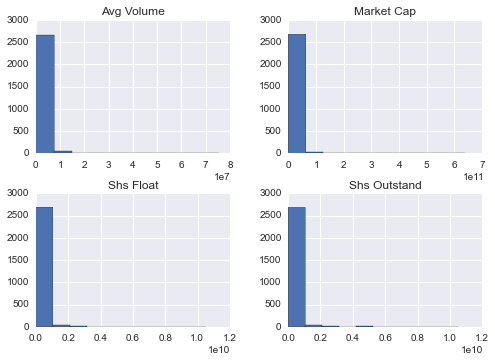

In [12]:
#Plot these to see the distribution
df_tickerDataSet[['Avg Volume', 'Shs Outstand', 'Shs Float', 'Market Cap',]].hist()

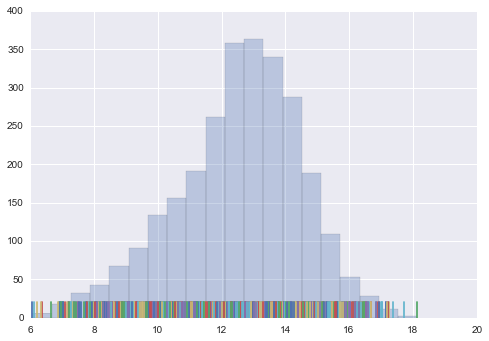

In [13]:
#Data is skewed. So plot Log of Shares Outstanding to see the distribution
sns.plt.hist(np.log(df_tickerDataSet['Avg Volume']), 20, alpha=0.3)
sns.rugplot(np.log(df_tickerDataSet['Avg Volume']))

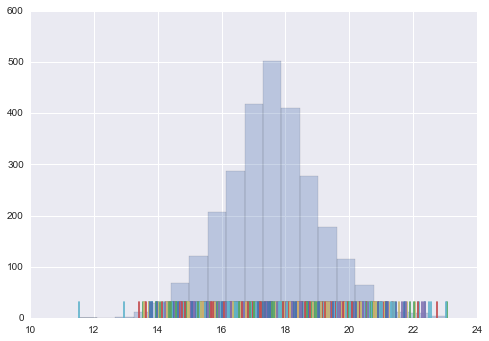

In [14]:
#Data is skewed. So plot Log of Shares Outstanding to see the distribution
sns.plt.hist(np.log(df_tickerDataSet['Shs Float']), 20, alpha=0.3)
sns.rugplot(np.log(df_tickerDataSet['Shs Float']))

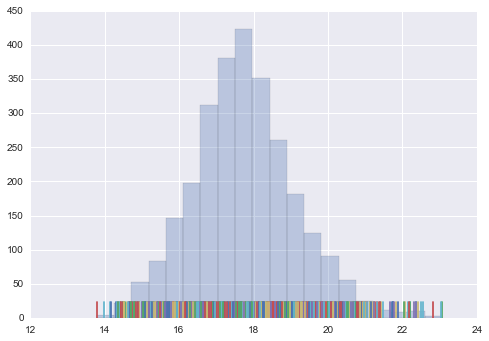

In [15]:
#Data is skewed. So plot Log of Shares Outstanding to see the distribution
sns.plt.hist(np.log(df_tickerDataSet['Shs Outstand']), 20, alpha=0.3)
sns.rugplot(np.log(df_tickerDataSet['Shs Outstand']))

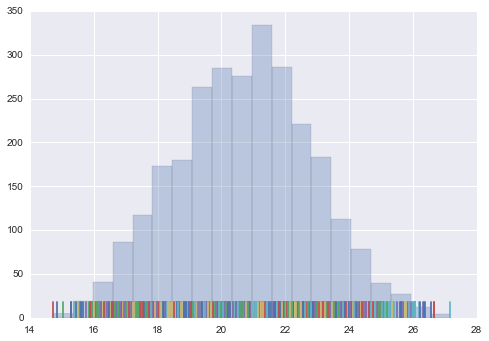

In [16]:
#Data is kind of skewed to the left, so taking logarithms of market cap
sns.plt.hist(np.log(df_tickerDataSet['Market Cap']), 20, alpha=0.3)
sns.rugplot(np.log(df_tickerDataSet['Market Cap']))

In [17]:
#Setting Log of marketCap as the target (dependent variable) y for Regression
df_y = np.log(df_tickerDataSet['Market Cap'])
#Dropping market cap from the main independenct variable X dataset
#Setting the log for variables we figured out in the visualizations above
df_x = df_tickerDataSet.drop(['Market Cap'], axis=1)
df_x['Shs Outstand'] = np.log(df_tickerDataSet['Shs Outstand'])
df_x['Shs Float'] = np.log(df_tickerDataSet['Shs Float'])
df_x['Avg Volume'] = np.log(df_tickerDataSet['Avg Volume'])

In [18]:
#Using Stats models for Linear Regression
regressionCount = 1
old_adjRsquare = 0.0

#Adding column for Constant in the independent variable X dataframe
sm.add_constant(df_x)
#Fit and summarize OLS model
mod = sm.OLS(df_y, df_x)
res = mod.fit()
print res.summary()
old_adjRsquare = res.rsquared_adj
print("First Regression Adjusted R-Square: %0.4f" %old_adjRsquare)

                            OLS Regression Results                            
Dep. Variable:             Market Cap   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.388e+04
Date:                Tue, 24 Mar 2015   Prob (F-statistic):               0.00
Time:                        15:26:56   Log-Likelihood:                -2467.2
No. Observations:                2743   AIC:                             5056.
Df Residuals:                    2682   BIC:                             5417.
Df Model:                          61                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
52W High                 0.0153      0.002     10.143      0.000         0.012     0.018
52W Low               

In [19]:
new_adjRSquare = 1.0
while new_adjRSquare > old_adjRsquare:
    if new_adjRSquare != 1:
        old_adjRsquare = new_adjRSquare
        
    regressionCount += 1       
    print("Dropping Max p-Value Attribute: "+ res.params[res.pvalues == max(res.pvalues)].index[0] + " from X Variables")
    maxPvalue_Param = res.params[res.pvalues == max(res.pvalues)].index[0]
    df_x.drop([maxPvalue_Param], axis=1, inplace=True)
    
    mod = sm.OLS(df_y, df_x)
    res = mod.fit()
    #print res.summary()
    new_adjRSquare = res.rsquared_adj
    print("Internal Regression Adjusted R-Square: %0.4f" %new_adjRSquare)

Dropping Max p-Value Attribute: Forward P/E from X Variables
Internal Regression Adjusted R-Square: 0.9992
Dropping Max p-Value Attribute: PEG from X Variables
Internal Regression Adjusted R-Square: 0.9992
Dropping Max p-Value Attribute: Sales Q/Q from X Variables
Internal Regression Adjusted R-Square: 0.9992
Dropping Max p-Value Attribute: Insider Own from X Variables
Internal Regression Adjusted R-Square: 0.9992
Dropping Max p-Value Attribute: EPS Q/Q from X Variables
Internal Regression Adjusted R-Square: 0.9992
Dropping Max p-Value Attribute: Perf Year from X Variables
Internal Regression Adjusted R-Square: 0.9992
Dropping Max p-Value Attribute: SMA200 from X Variables
Internal Regression Adjusted R-Square: 0.9992
Dropping Max p-Value Attribute: Employees from X Variables
Internal Regression Adjusted R-Square: 0.9992
Dropping Max p-Value Attribute: Perf Half Y from X Variables
Internal Regression Adjusted R-Square: 0.9992
Dropping Max p-Value Attribute: ROE from X Variables
Interna

In [20]:
#print res.summary()
print("Number of Significant Attributes in the Dataset with alpha(0.05): %d" %len(res.params[res.pvalues <= 0.05]))

Number of Significant Attributes in the Dataset with alpha(0.05): 31


In [21]:
sig_Attributes = list(res.params[res.pvalues <= 0.05].index)
print sig_Attributes

[u'52W High', u'ATR', u'Avg Volume', u'Beta', u'Book/sh', u'Current Ratio', u'Debt/Eq', u'Dividend', u'Dividend %', u'EPS (ttm)', u'EPS next 5Y', u'EPS past 5Y', u'Insider Trans', u'Inst Own', u'LT Debt/Eq', u'Oper. Margin', u'P/B', u'Perf Month', u'Perf Quarter', u'Perf Week', u'Quick Ratio', u'ROA', u'RSI (14)', u'SMA20', u'SMA50', u'Sales', u'Short Float', u'Short Ratio', u'Shs Outstand', 'Volatility (Weekly)', 'Volatility (Monthly)']


In [22]:
#Take only the subset of the ticker dataset with significant attributes
df_sigTickerAttributes = df_tickerDataSet[sig_Attributes]
print df_sigTickerAttributes.shape

(2743, 31)


In [23]:
df_sigTickerAttributes = pd.concat([df_sigTickerAttributes, df_tickerDataSet['Market Cap']], axis=1)
print df_sigTickerAttributes.ix[:,-1:].head()

        Market Cap
A     1.272000e+10
AA    1.892000e+10
AAON  1.180000e+09
AAP   1.114000e+10
AAPL  6.376300e+11


In [24]:
from sklearn import neighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import scale
from seaborn import plt

In [25]:
#Re-load Original Dataset for KNN
df_tickerDataSet = pd.read_excel(CONST_IN_FILE)
df_tickerDataSet = clean_tickerDataframe(df_tickerDataSet)
df_tickerDataSet = df_tickerDataSet[(df_tickerDataSet['P/E'] > 0) & (df_tickerDataSet['P/E'].notnull())]
print df_tickerDataSet.shape

(2022, 62)


In [26]:
#Drop the P/E out of Dataset and set it as dependent variable
df_y = df_tickerDataSet['P/E']
df_x = df_tickerDataSet.drop(['P/E'], axis=1)
#Load only the significant attributes of the regression and concatenate the Market Cap
df_x = df_tickerDataSet[sig_Attributes]
df_x = pd.concat([df_x, df_tickerDataSet['Market Cap']], axis=1)

#Scaling the following variables for KNN
df_x['Shs Outstand'] = scale(df_x['Shs Outstand'])
df_x['Avg Volume'] = scale(df_tickerDataSet['Avg Volume'])
df_x['Market Cap'] = scale(df_tickerDataSet['Market Cap'])

In [27]:
#Neighbors variables we'll need to set intially.
n_neighbors = range(1, 20, 1)
scores = []
for n in n_neighbors:
    knn_regressor = neighbors.KNeighborsRegressor(n_neighbors=n)
    knn_regressor = knn_regressor.fit(df_x.values, df_y.values)
    y_predict = knn_regressor.predict(df_x.values)
    score = knn_regressor.score(df_x.values, df_y.values)
    scores.append(score)
print scores

[1.0, 0.68298110651040966, 0.3938611253430373, 0.32048117195069048, 0.24144846068154446, 0.1914552659977895, 0.14964001459488263, 0.12289183604182841, 0.10116475763189814, 0.10042656613235812, 0.081534497461585698, 0.074870120634617399, 0.069856393914736303, 0.06784228609458709, 0.063646201631077703, 0.05503820902051304, 0.05108580579399391, 0.05274739795220007, 0.048166366012531214]


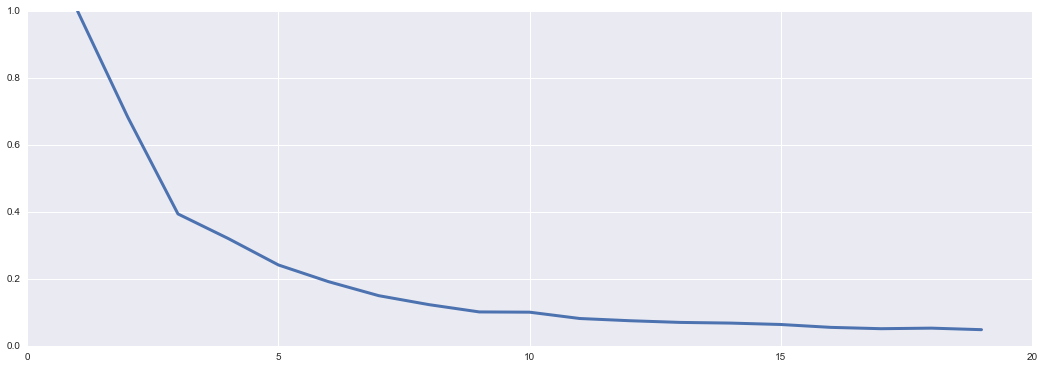

In [28]:
plt.figure(figsize=(18,6))
_ = plt.plot(n_neighbors, scores, linewidth=3.0)

In [29]:
#Looks like n=2 is the best bet
knn_regressor = neighbors.KNeighborsRegressor(n_neighbors=2)
knn_regressor = knn_regressor.fit(df_x.values, df_y.values)
y_predict = knn_regressor.predict(df_x.values)
print "Predicted P/E Ratios:", y_predict
print "Score of Model:", knn_regressor.score(df_x.values, df_y.values)

Predicted P/E Ratios: [  20.26    43.525   24.025 ...,   37.07   170.73    15.91 ]
Score of Model: 0.68298110651


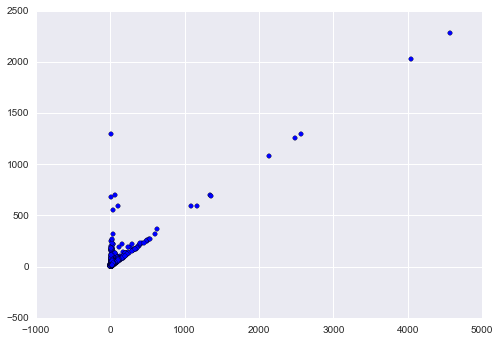

In [30]:
plt.scatter(df_y.values,y_predict)

In [31]:
#Cross Validate the KNN
from sklearn.cross_validation import cross_val_score
knn_regressor = neighbors.KNeighborsRegressor(n_neighbors=2)
scores = cross_val_score(knn_regressor, df_x.values, df_y.values, cv=15)
print scores
print "Mean Predicted Accuracy: %0.2f" % np.mean(scores)

[ -0.43030852  -0.78921386  -0.97458052  -0.01310031  -0.44313533
  -1.13470083  -8.82401901  -0.69886653  -0.4249748   -0.09601599
 -11.01940138  -2.3377804   -0.92477532  -8.53859097  -0.12292775]
Mean Predicted Accuracy: -2.45


In [32]:
#Re-load Original Dataset for Gradient Boost Regression
df_tickerDataSet = pd.read_excel(CONST_IN_FILE)
df_tickerDataSet = clean_tickerDataframe(df_tickerDataSet)
df_tickerDataSet = df_tickerDataSet[(df_tickerDataSet['P/E'] > 0) & (df_tickerDataSet['P/E'].notnull())]
print df_tickerDataSet.shape

(2022, 62)


In [33]:
#Drop the P/E out of Dataset and set it as dependent variable
df_y = df_tickerDataSet['P/E']
df_x = df_tickerDataSet.drop(['P/E'], axis=1)
df_x = df_tickerDataSet[sig_Attributes]
df_x = pd.concat([df_x, df_tickerDataSet['Market Cap']], axis=1)

df_x['Shs Outstand'] = scale(df_x['Shs Outstand'])
df_x['Avg Volume'] = scale(df_tickerDataSet['Avg Volume'])
df_x['Market Cap'] = scale(df_tickerDataSet['Market Cap'])
print df_x.shape
print df_y.shape

(2022, 32)
(2022,)


In [34]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=12)
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(1415, 32) (1415,) (607, 32) (607,)


In [35]:
assert not np.any(np.isnan(X_train) | np.isinf(X_train))
assert not np.any(np.isnan(y_train) | np.isinf(y_train))
assert not np.any(np.isnan(X_test) | np.isinf(X_test))
assert not np.any(np.isnan(y_test) | np.isinf(y_test))

In [36]:
#GradientBoost Regression
from sklearn.ensemble import GradientBoostingRegressor
GBoost_Regressor1 = GradientBoostingRegressor(n_estimators=500, max_depth=3)
GBoost_Regressor1.fit(X_train, y_train)
GBoost_Regressor1

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2, n_estimators=500,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [37]:
y_predict = GBoost_Regressor1.predict(X_train)
y_predict

array([ 146.61266305,   49.13567076,   13.42838683, ...,   20.2278157 ,
         14.15702924,   27.91516965])

In [38]:
GBoost_Regressor1.score(X_train,y_train)

0.99990985063060411

In [39]:
y_test_predict = GBoost_Regressor1.predict(X_test)

In [40]:
GBoost_Regressor1.score(X_test,y_test)

0.5776160816314091

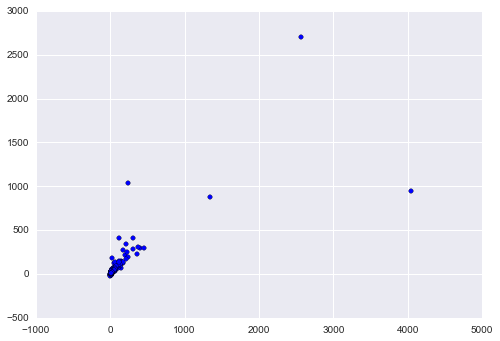

In [41]:
plt.scatter(y_test,y_test_predict)

In [42]:
from sklearn.grid_search import GridSearchCV
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [2,4,6],
              'min_samples_leaf': [2,4,6]}

est = GradientBoostingRegressor(n_estimators=500, max_depth=5, learning_rate=1.0)
gs_cv = GridSearchCV(est, param_grid, scoring='mean_squared_error', n_jobs=4).fit(X_train, y_train)

#Best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 2}


In [43]:
# GradientBoost fit estimator
GBoost_Regressor2 = GradientBoostingRegressor(n_estimators=500, learning_rate = 0.1, 
                                             max_depth = 2, min_samples_leaf = 2)
GBoost_Regressor2.fit(X_train, y_train)
GBoost_Regressor2

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=2, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=2, min_samples_split=2, n_estimators=500,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [44]:
y_predict = GBoost_Regressor2.predict(X_train)
y_predict

array([ 133.74810953,   40.8885558 ,   11.43400702, ...,   25.93078715,
         15.57880045,   26.76591243])

In [45]:
GBoost_Regressor2.score(X_train,y_train)

0.998616916866785

In [46]:
y_test_predict = GBoost_Regressor2.predict(X_test)

In [47]:
GBoost_Regressor2.score(X_test,y_test)

0.75140006880087507

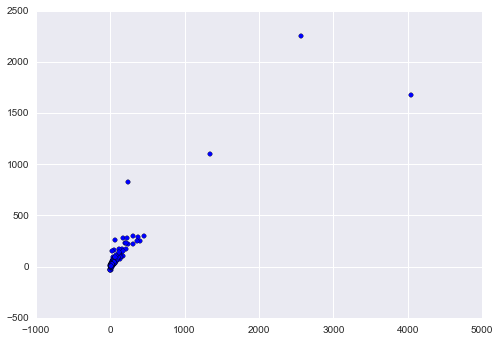

In [48]:
plt.scatter(y_test,y_test_predict)

In [49]:
#Cross validate the GBRT model
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(GBoost_Regressor2, df_x.values, df_y.values, cv=15)
print scores

[ 0.87401767  0.76428671  0.8496229   0.61215092  0.37037166  0.90531891
  0.83075582  0.68142711  0.98779102  0.96318189  0.83790401  0.9347221
  0.6888003   0.73232537  0.91747772]


In [50]:
print "Mean Predicted Accuracy: %0.2f" % (np.mean(scores)*100) + "%"

Mean Predicted Accuracy: 79.67%


In [51]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
y_predict = GBoost_Regressor2.predict(df_x.values)
print "Explained Variance Score: %f" %explained_variance_score(df_y.values,y_predict)
print "Mean Absolute Error: %f" %mean_absolute_error(df_y.values,y_predict)
print "Coefficient of determination.: %f" %r2_score(df_y.values,y_predict)
from sklearn.metrics import r2_score

Explained Variance Score: 0.901715
Mean Absolute Error: 6.708918
Coefficient of determination.: 0.901674


In [52]:
df_pred_values = pd.DataFrame(data = {'Predicted P/E': y_predict, 'Market P/E': df_tickerDataSet['P/E'].values}, 
                              index=df_tickerDataSet.index)
print y_predict.shape, df_tickerDataSet.shape
print df_pred_values.head()

(2022,) (2022, 62)
      Market P/E  Predicted P/E
A          25.46      24.697395
AA         70.68      73.215725
AAON       29.22      29.985926
AAP        24.50      26.767372
AAPL       16.91      16.229055


In [71]:
print df_pred_values.ix[['FB', 'V', 'WFC', 'GILD', 'CSCO']]

      Market P/E  Predicted P/E
FB         72.61      64.974249
V          29.69      20.196869
WFC        12.68      12.400238
GILD       18.37      20.936133
CSCO       18.97      23.643589


# Over/Fairly or Under Valued :).
# Definitely <U> not a good idea </U> to pick stocks based on this.
# Interesting to understand how Hi-Frequency Trades work today.
# Questions?